<a href="https://colab.research.google.com/github/toufiqmusah/CALADAN/blob/main/02_Ocular_Disease_Classification(EfficientNet)%7CFine_Tune_CALADAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DATA PREPARATION

IMPORTING LIBRARIES

In [ ]:
import shutil
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install -q torchinfo
from torchinfo import summary

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.utils import make_grid
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device, torch.__version__, os.cpu_count()

(device(type='cpu'), '2.2.1+cu121', 2)

GETTING DATA

In [ ]:
!gdown -qq 1F_k5qvgvPldUEPNlunM49inPnI8Ti8GY
!unzip -qq '/content/OCULAR-DISEASE-DATASET.zip'

In [ ]:
data_df = pd.read_csv('/content/full_df.csv')

In [ ]:
path = '/content/ODIR-5K/ODIR-5K'
img_name = data_df['filename'].iloc[0]
file = path + "Training Images/" + img_name

training_path = path + "Training Images/"

In [ ]:
print(f"Train : {len(os.listdir('/content/ODIR-5K/ODIR-5K/Training Images'))}, Test : {len(os.listdir('/content/ODIR-5K/ODIR-5K/Testing Images'))}, Prepocess : {len(os.listdir('/content/preprocessed_images'))}")

Train : 7000, Test : 1000, Prepocess : 6392


In [ ]:
data_df['labels'].unique()

array(["['N']", "['D']", "['O']", "['M']", "['H']", "['C']", "['A']",
       "['G']"], dtype=object)

Creating Dataset Folders

In [ ]:
!mkdir ODIR-Dataset

In [ ]:
label_map = { "['N']" : 'Normal', "['D']" : 'Diabetic Ret',
             "['G']" : 'Glaucoma', "['O']" : 'Other Disease',
             "['H']" : 'Hypertension', "['M']" : 'Myopia',
             "['A']" : 'AMD', "['C']" : 'Cataract'}

data_df['labels'] = data_df['labels'].map(label_map)

source_dir = '/content/preprocessed_images'
destination_dir = '/content/ODIR-Dataset'

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

for index, row in data_df.iterrows():
    source_file = os.path.join(source_dir, row['filename'])
    label_dir = os.path.join(destination_dir, row['labels'])
    ensure_dir(label_dir)

    destination_file = os.path.join(label_dir, row['filename'])
    shutil.move(source_file, destination_file)

print("Files have been organized into label-based directories.")


Files have been organized into label-based directories.


In [ ]:
data_path = '/content/ODIR-Dataset'

In [ ]:
!rm -rf '/content/ODIR-Dataset/Other Disease'
!rm -rf '/content/ODIR-Dataset/Myopia'
!rm -rf '/content/ODIR-Dataset/Hypertension'
!rm -rf '/content/ODIR-Dataset/AMD'
!rm -rf '/content/ODIR-Dataset/Glaucoma'

Visualising Class Image Grids

In [ ]:
data_transforms = transforms.Compose([transforms.Resize(size = (128, 128)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins = 5),
                                      transforms.ToTensor()])

all_data = datasets.ImageFolder(root = data_path, transform = data_transforms)

all_data_loader = DataLoader(all_data, batch_size = 64, shuffle = True)

Visualizing Some Data

(-0.5, 1041.5, 521.5, -0.5)

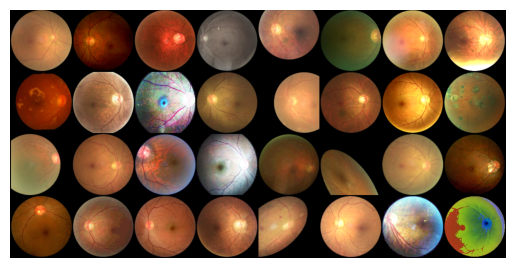

In [ ]:
images, labels = next(iter(all_data_loader))
grid = make_grid(images[:32], normalize = True)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')

Creating DataLoaders

In [ ]:
images[0].shape

torch.Size([3, 128, 128])

In [ ]:
batch_size = 64

train_data, test_data, valid_data = random_split(all_data, [0.7, 0.2, 0.1])

train_dataloader = DataLoader(train_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)
valid_dataloader = DataLoader(valid_data, batch_size = batch_size)

classes = all_data.classes

len(classes), train_dataloader, test_dataloader, valid_dataloader

(3,
 <torch.utils.data.dataloader.DataLoader at 0x7f344414d1b0>)

#MODEL IMPLEMENTATION

In [ ]:
!git clone -qq https://github.com/toufiqmusah/CALADAN.git

In [ ]:
from CALADAN.modular_torch import engine, data_setup

Creating Model-Specific DataLoaders

In [ ]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
weights

EfficientNet_B1_Weights.IMAGENET1K_V2

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

custom_transforms = [transforms.TrivialAugmentWide(num_magnitude_bins = 8)]

all_transforms = transforms.Compose([
    *custom_transforms,
    auto_transforms
])

all_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=8, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [ ]:
all_data = datasets.ImageFolder(root = data_path, transform = all_transforms)

all_data_loader = DataLoader(all_data, batch_size = 64, shuffle = True)

In [ ]:
batch_size = 64

train_data, test_data, valid_data = random_split(all_data, [0.7, 0.2, 0.1])

train_dataloader = DataLoader(train_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)
valid_dataloader = DataLoader(valid_data, batch_size = batch_size)

classes = all_data.classes

len(classes), train_dataloader, test_dataloader, valid_dataloader

(3,
 <torch.utils.data.dataloader.DataLoader at 0x7f34442e0400>)

In [22]:
torch.save(valid_dataloader, '/content/validation-data')

(-0.5, 1041.5, 521.5, -0.5)

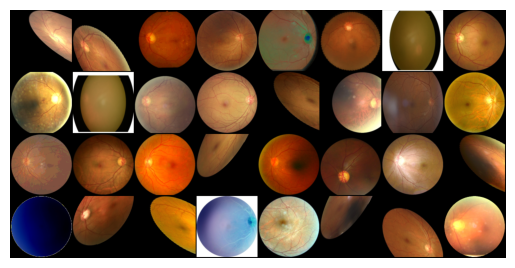

In [ ]:
images_1, labels_1 = next(iter(all_data_loader))
grid = make_grid(images[:32], normalize = True)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')

Setting Up a Pre-Trained Model

In [ ]:
model = torchvision.models.efficientnet_b1(weights = weights).to(device)

summary(model = model,
        input_size = (64, 3, 255, 255),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 24,
        row_settings = ['var_names']
)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 141MB/s]


Layer (type (var_name))                                      Input Shape              Output Shape             Param #                  Trainable
EfficientNet (EfficientNet)                                  [64, 3, 255, 255]        [64, 1000]               --                       True
├─Sequential (features)                                      [64, 3, 255, 255]        [64, 1280, 8, 8]         --                       True
│    └─Conv2dNormActivation (0)                              [64, 3, 255, 255]        [64, 32, 128, 128]       --                       True
│    │    └─Conv2d (0)                                       [64, 3, 255, 255]        [64, 32, 128, 128]       864                      True
│    │    └─BatchNorm2d (1)                                  [64, 32, 128, 128]       [64, 32, 128, 128]       64                       True
│    │    └─SiLU (2)                                         [64, 32, 128, 128]       [64, 32, 128, 128]       --                       --
│    └─Seq

Freezing Base Layers

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

Editing Final Layers of EfficientNet-B1

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2,inplace =True),
    torch.nn.Linear(in_features = 1280,
                    out_features = output_shape,
                    bias = True).to(device)
)

Setting Up Model Hyper Parameters

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-3)

model_result = engine.train(model = model,
                            train_dataloader = train_dataloader,
                            test_dataloader = test_dataloader,
                            optimizer = optimizer,
                            loss_fn = criterion,
                            epochs = 60,
                            device = device)

[INFO] Couldn't find helper_functions.py, downloading...


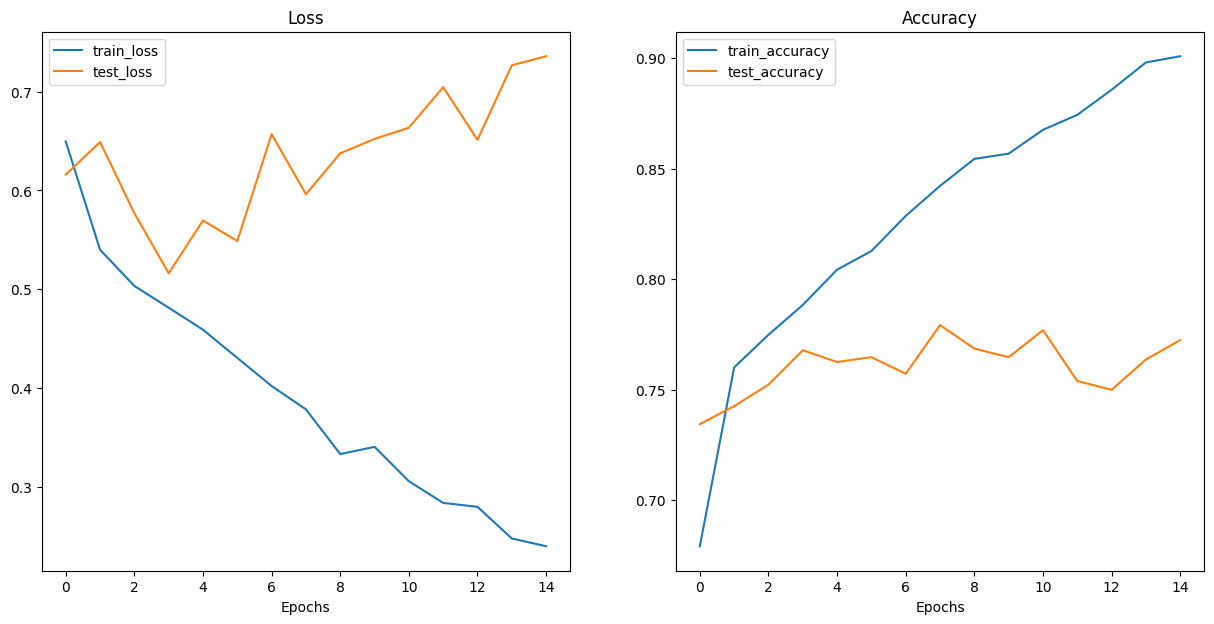

In [ ]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_result)

In [ ]:
torch.save(model, '/content/CALADAN-EfficientNet-')